In [39]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import shapely
import networkx as nx
import pysal as ps
import pandas as pd

import geopandas as gp

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
%matplotlib inline

In [2]:
def plot_polygons(geoms, ax, values=None, colormap='Set1', facecolor=None, edgecolor=None,
                            alpha=1.0, linewidth=1.0, **kwargs):
    """Makes a MatPlotLib PatchCollection out of Polygon and/or MultiPolygon geometries 
     Thanks to http://stackoverflow.com/a/33753927 and David Sullivan"""
    
    # init list to store 
    patches = []
    newvals = []
    
    for polynum in range(len(geoms)):                          # for  polygon # i
        poly = geoms.iloc[polynum]                              # find data.geometry[i] 
        if type(poly) != shapely.geometry.polygon.Polygon:     # if that is not a shapely Polygon object
            for currpoly in poly.geoms:                         # then for data.geometry[i].geoms
                a = np.asarray(currpoly.exterior)                  # make a an array of those exterior values and
                patches.append(Polygon(a))                           # append ato patches
                if values is not None:                               # if values, add value to newvals
                    newvals.append(values.iloc[polynum])
        else:
            a = np.asarray(poly.exterior)
            patches.append(Polygon(a))
            if values is not None:
                newvals.append(values.iloc[polynum])

    patches = PatchCollection(patches, 
                              facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, alpha=alpha, 
                              **kwargs)
    if values is not None:
        patches.set_array(np.asarray(newvals))
        patches.set_cmap(colormap)
        norm = matplotlib.colors.Normalize()
        norm.autoscale(newvals)
        patches.set_norm(norm)
    ax.add_collection(patches, autolim=True)
    ax.autoscale_view()
    return patches

In [3]:
# see which dir we're in since we need to access data
!pwd

/Users/jared/Desktop/geo187/Randomized_Election/code


## Read in data

Now, let's read in the data.

Our dataset, `election`, has informatino about every county in the United States.
For each county we possess informatin such as `votes`, `margin`, etc.

In [4]:
election = gp.read_file('../data/election-map.shp')

In [5]:
election.head(n=5)

,FID,dem,dempc,geometry,gop,goppc,grn,lib,margin,name,newstate,oth,population,state,una,votes
0,1001,5908,0.239569,"POLYGON ((892112.80012558 1115678.795392964, 8...",18110,0.734358,105,538,0.494789,Autauga,AL,0,54571,AL,0,24661
1,1003,18409,0.195653,"POLYGON ((780232.5698541742 947375.2080644479,...",72780,0.773515,453,2448,0.577862,Baldwin,AL,0,182265,AL,0,94090
2,1005,4848,0.466603,"POLYGON ((1026127.598653847 1057957.143773036,...",5431,0.522714,18,93,0.056112,Barbour,AL,0,27457,AL,0,10390
3,1007,1874,0.214220,"POLYGON ((845034.8675876737 1149437.158844963,...",6733,0.769662,17,124,0.555441,Bibb,AL,0,22915,AL,0,8748
4,1009,2150,0.084699,"POLYGON ((871035.6126721548 1287748.49965, 886...",22808,0.898519,89,337,0.813820,Blount,AL,0,57322,AL,0,25384


In [6]:
test= election.geometry[2].exterior

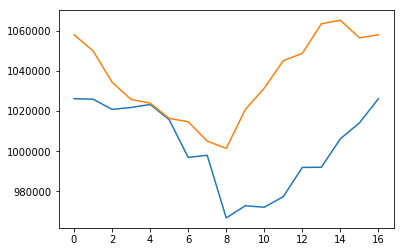

In [7]:
# below won't work because we're dealing with a polygon obect
plt.plot(test)

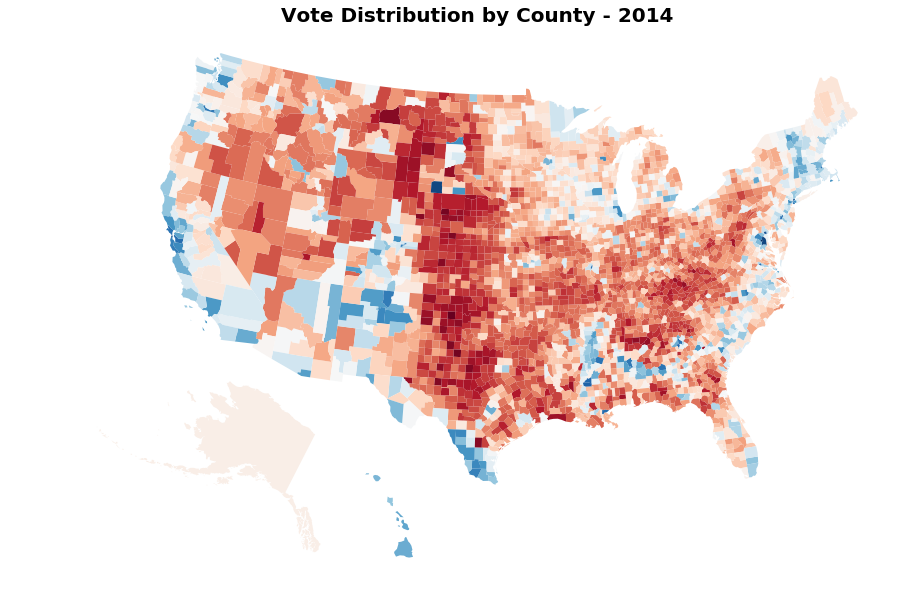

In [8]:
fig, ax = plt.subplots(figsize=(15,11))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Vote Distribution by County - 2014', fontsize=20, fontweight='bold')
plot_polygons(ax=ax, geoms=election.geometry, linewidth=.91, values=election.goppc, colormap='RdBu_r')

In [9]:
def plot_counties(polyg):
    fig, ax = plt.subplots(figsize=(15,11))
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Vote Distribution by County - 2014', fontsize=20, fontweight='bold')
    plot_polygons(ax=ax, geoms=polyg.geometry, linewidth=.91, values=polyg.goppc, colormap='RdBu_r')

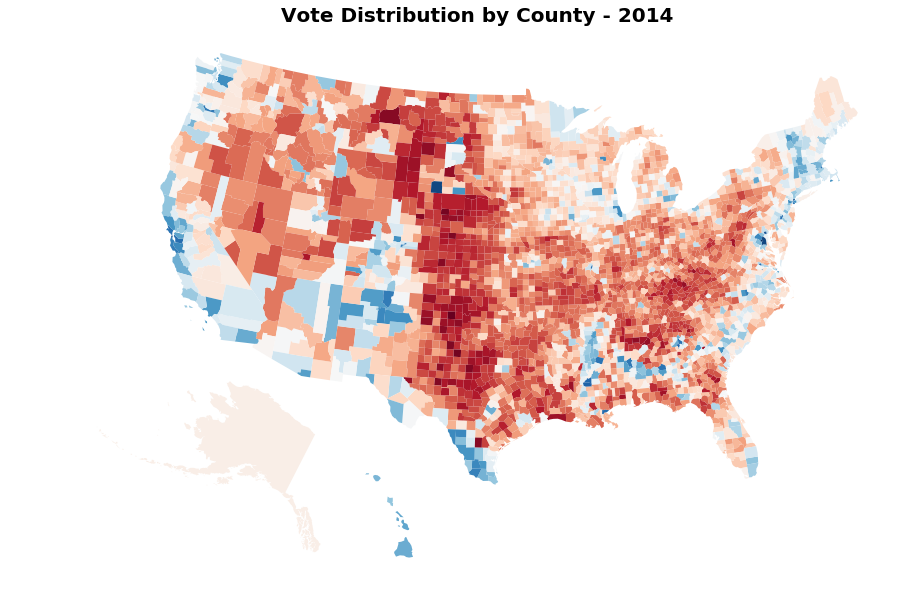

In [10]:
plot_counties(election)

In [11]:
election.shape

(3092, 16)

In [12]:
election.head()

,FID,dem,dempc,geometry,gop,goppc,grn,lib,margin,name,newstate,oth,population,state,una,votes
0,1001,5908,0.239569,"POLYGON ((892112.80012558 1115678.795392964, 8...",18110,0.734358,105,538,0.494789,Autauga,AL,0,54571,AL,0,24661
1,1003,18409,0.195653,"POLYGON ((780232.5698541742 947375.2080644479,...",72780,0.773515,453,2448,0.577862,Baldwin,AL,0,182265,AL,0,94090
2,1005,4848,0.466603,"POLYGON ((1026127.598653847 1057957.143773036,...",5431,0.522714,18,93,0.056112,Barbour,AL,0,27457,AL,0,10390
3,1007,1874,0.214220,"POLYGON ((845034.8675876737 1149437.158844963,...",6733,0.769662,17,124,0.555441,Bibb,AL,0,22915,AL,0,8748
4,1009,2150,0.084699,"POLYGON ((871035.6126721548 1287748.49965, 886...",22808,0.898519,89,337,0.813820,Blount,AL,0,57322,AL,0,25384


# Plans

1. Identify partisan and non-partisan states
2. Within each state, randomize the creation of networks

# Create Graph Instance

1. Init Graph
2. Create `neighbors`: Rook data-structure that holds neighbor relationships
    (Can any of these be greater than 1?i.e., can you have same neighbor >1 time?)
3. Initialize graph nodes as 0,1,2,...,3091  
    (number of counties)
4. Add nodes to graph
5. Add state name to graph

In [13]:
# This sets up the initial graph structure

# Init Graph Instance
G = nx.Graph()

# This calculates the weights between the edges for our graph
neighbors = ps.weights.Contiguity.Rook.from_dataframe(election)


# To make graph, we must first initialize nodes
G.add_nodes_from(range(len(election.state)))


# now read the pysal neighbors structure
# and add edges to the graph accordingly
for i, Ni in neighbors:                # i corresponds to county, Ni: neighboring counties
    edges = [(i, j) for j in Ni]      # create an edge between i and each of its neighbors
    G.add_edges_from(edges)            # add this edge to graph
    
    
    
    
# #
# and now add the state affiliation of each as a node attribute
for i in G.nodes():
    G.node[i]['state'] = election.loc[i].state
    
G.nodes(data=True)[:5] # take a look at the first 5 nodes, for reference

/Users/jared/miniconda2/envs/geo/lib/python2.7/site-packages/pysal/weights/weights.py:189: UserWarning: There are 5 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/jared/miniconda2/envs/geo/lib/python2.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 67, 518, 519, 520, 521
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


[(0, {'state': u'AL'}),
 (1, {'state': u'AL'}),
 (2, {'state': u'AL'}),
 (3, {'state': u'AL'}),
 (4, {'state': u'AL'})]

# Questions

1. What is a "Rook" object?
2. In the `G.add_nodes_from(range(len(election.state))): for i, Ni in neighbors: ...` does this work just because the former addes nodes 0,1,2,... so the other can connect to them? I don't see how they connect otherwise
3.
    
    

# Randomly seed counties

1. Create set of states
2. for each state, make a list of all counties in that state
3. Randomly select a county for each state, store in **`seeds`**

In [14]:
import random # python built in random library

# now make some 'seed' counties
state_ids = set(election.state)
seeds = []
for s in state_ids: # for each state                  -> add county to that state
    this_state = [n[0] for n in G.nodes(data=True) if n[1]['state'] == s]
    seeds.append(random.choice(this_state))

In [15]:
def randomize_election():
    # now make some 'seed' counties
    state_ids = set(election.state)
    seeds = []
    for s in state_ids: # for each state                  -> add county to that state
        this_state = [n[0] for n in G.nodes(data=True) if n[1]['state'] == s]
        seeds.append(random.choice(this_state))
    node_shortest_paths = {n: (1000, -1, "XX") for n in G.nodes()}

    # for the islands, initialize so that the values won't be overwritten
    for x in neighbors.islands:
        node_shortest_paths[x] = (0, 0, election.loc[x].state)   
        
    # Determine shortest paths to all nodes from the seed counties
    distances_from_seeds = [nx.single_source_shortest_path_length(G, n) for n in seeds]

    # Now iterate
    for (seed, distances, state_id) in zip(seeds, distances_from_seeds, state_ids):
        for target, d in distances.items():     #(0,46), (1,43), (2,48), ...
            if d < node_shortest_paths[target][0]:   # find closest county to each county
                node_shortest_paths[target] = (d, seed, state_id)   # update so (shortest_distance, seed, )
                
    nearest_states = [node_shortest_paths[i][2] for i in node_shortest_paths]
    election.newstate = nearest_states
    states = make_states(election, st='newstate')
    return states




def plot_single_new_states(states):
    fig, ax = plt.subplots(figsize=(15,11))
    for p, t in zip(states.geometry, states.newstate):
        # set up text
        ax.annotate(xy=(p.centroid.x-40000, p.centroid.y), s=t)
        # plot states
        ax.set_title("Randomly Generated United States of America", fontsize=20)
        fig.suptitle('New Map of America', fontsize=20, fontweight='bold')
        ax.axis('off')
    states.plot(ax=ax, column='newstate', cmap="Vega20", linewidth=0)

In [16]:
print len(state_ids)
print len(seeds)
print len(this_state)
print len(G.nodes(data=True))

# how can this_state be len 66 if len(state_ids) == 51?

51
51
66
3092


# Create dictionary for each county/node

1. Initialize **`node_shortest_paths`** dictionary:
    (shortest path, source seed, state acronym)
2. Initialize island values (only 5 of them)

In [17]:
# now make a dictionary recording for each node
# shortest path, the source seed, and state ID
# initialize these to very long (1000), -1 (non-existent) and 'XX'
node_shortest_paths = {n: (1000, -1, "XX") for n in G.nodes()}

# for the islands, initialize so that the values won't be overwritten
for x in neighbors.islands:
    node_shortest_paths[x] = (0, 0, election.loc[x].state)

# Determine shortest paths to nodes from seed counties

1. Find shortest path to each node from seed counties:
    Create list of dicts, each dict key is county, value is distance from that county to the seed
    i.e. element 0 of list stores min distance for each county to 0th seed.
    
2. for each county:
    find closest 

In [18]:
# Determine shortest paths to all nodes from the seed counties
distances_from_seeds = [nx.single_source_shortest_path_length(G, n) for n in seeds]

# Now iterate
for (seed, distances, state_id) in zip(seeds, distances_from_seeds, state_ids):
    for target, d in distances.items():     #(0,46), (1,43), (2,48), ...
        if d < node_shortest_paths[target][0]:   # find closest county to each county
            node_shortest_paths[target] = (d, seed, state_id)   # update so (shortest_distance, seed, )
            

# node_shortest_paths dict

for each seed, bring along the distance list and state_id of that seed
    then, for each county and distance to that seed
        if the distance for that county is the minimum distance
            update the dict to track that new minimum distance, the seed it's closest to, and the state of that seed
            
Resulting dict:   [ **minimum distance to seed**, **closest seed**, **state of seed**]

Thus, each county is now linked to a closest seed, along with that seeds state

The process is as follows:

    - Randomly select a county for each state, call this the `seed`
    - For every county, find the seed it's closest too
    - Assign the county to this new seed's state

In [19]:
1.0*len(election['newstate'] == election['state'])/election.shape[0]

1.0

`distances_from_seeds` is a list of len 51, where each element in the list is a dictionary.
Each key in the dictionary is a county, and the **value** for that key is the shortest distance from that key to the selected seed county. 

i.e. key 0 stores the minimum distances for each county to seed 0.



In [20]:
print len(seeds)
print len(distances_from_seeds)
print len(state_ids)

51
51
51


In [21]:
nearest_states = [node_shortest_paths[i][2] for i in node_shortest_paths]
election.newstate = nearest_states

In [22]:
election[500:510]

,FID,dem,dempc,geometry,gop,goppc,grn,lib,margin,name,newstate,oth,population,state,una,votes
500,13287,1243,0.366667,"POLYGON ((1176255.278122723 1052362.942150211,...",2094,0.617699,0,53,0.251032,Turner,FL,0,8930,GA,0,3390
501,13289,1970,0.486060,"POLYGON ((1188913.259119319 1136926.239001329,...",2034,0.501850,0,49,0.015791,Twiggs,GA,0,9023,GA,0,4053
502,13291,1962,0.162970,"POLYGON ((1083021.902739637 1393810.504468895,...",9849,0.818091,0,228,0.655121,Union,GA,0,21356,GA,0,12039
503,13293,3471,0.317741,"POLYGON ((1086692.092290053 1169442.298917362,...",7288,0.667155,0,165,0.349414,Upson,GA,0,27153,GA,0,10924
504,13295,4213,0.175989,"POLYGON ((983397.3850359617 1357032.04096122, ...",18938,0.791094,0,788,0.615105,Walker,GA,0,68756,GA,0,23939
505,13297,8279,0.204799,"POLYGON ((1130886.032469955 1278101.550739474,...",31093,0.769153,0,1053,0.564354,Walton,GA,0,83768,GA,0,40425
506,13299,3436,0.282798,"POLYGON ((1282237.993100377 1018655.391045364,...",8508,0.700247,0,206,0.417449,Ware,FL,0,36312,GA,0,12150
507,13301,1313,0.563036,"POLYGON ((1255235.045294046 1228209.971980066,...",991,0.424957,0,28,-0.138079,Warren,GA,0,5834,GA,0,2332
508,13303,4187,0.497150,"POLYGON ((1222984.053413013 1215297.251331479,...",4138,0.491332,0,97,-0.005818,Washington,SC,0,21187,GA,0,8422
509,13305,2039,0.196511,"POLYGON ((1310145.538651011 1068860.565495147,...",8147,0.785177,0,190,0.588666,Wayne,SC,0,30099,GA,0,10376


# Now, we've randomized the state assignment. It's time to assign the states accordingly

In [23]:
def make_states(c, st='state'):
    st = c.dissolve(by=st, aggfunc='sum', as_index=False)
    st.dempc = st.dem / st.votes
    st.goppc = st.gop / st.votes
    st.margin = st.goppc - st.dempc
    st['win'] = 'D'
    st.loc[st.gop > st.dem, 'win'] = 'R'
    return st

In [24]:
states = make_states(election, st='newstate')

In [25]:
states.head()

,newstate,geometry,FID,dem,dempc,gop,goppc,grn,lib,margin,oth,population,una,votes,win
0,AK,(POLYGON ((-1882164.772212857 419730.666193547...,2001,93007,0.377176,130415,0.528878,4445,14593,0.151702,4128,710231,0,246588,R
1,AL,(POLYGON ((881156.8469885951 855009.1992311808...,849036,851971,0.359155,1457930,0.614603,9811,49846,0.255447,2593,5505612,0,2372151,R
2,AR,"POLYGON ((187755.7008467465 1189168.26751307, ...",1487254,477254,0.293165,1075255,0.660502,13393,47663,0.367337,14371,4083984,0,1627936,R
3,AZ,POLYGON ((-1365876.729939255 1021579.408853245...,319510,1851917,0.494778,1688734,0.451180,50540,146005,-0.043598,5732,11943290,0,3742928,D
4,CA,"POLYGON ((-2179243.116936406 1809137.0638182, ...",462122,3068842,0.637718,1450637,0.301449,90792,172659,-0.336270,29291,13277113,0,4812221,D


# plot new states

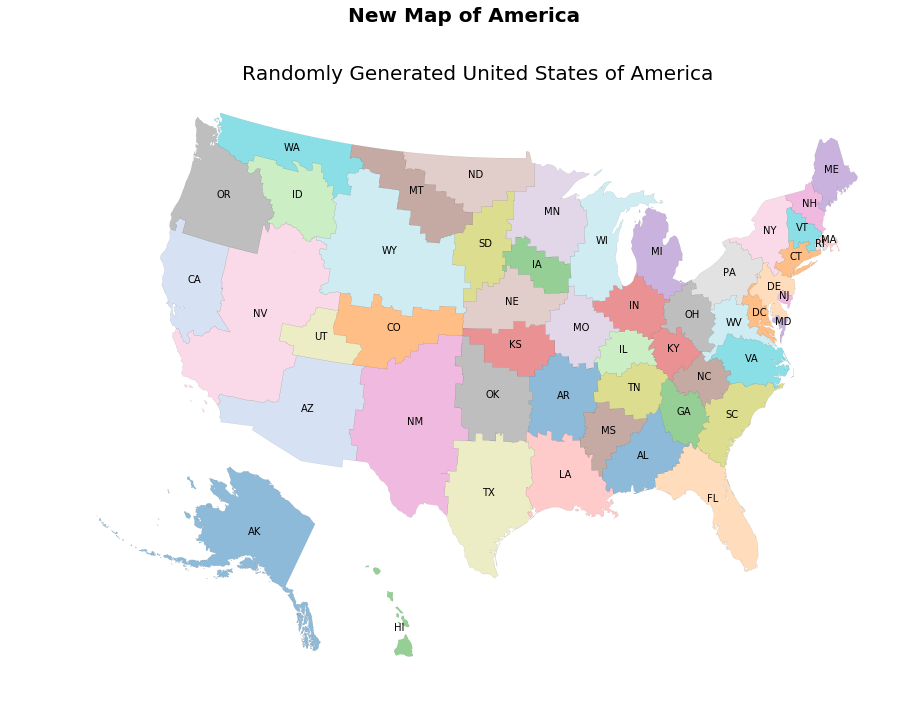

In [26]:
fig, ax = plt.subplots(figsize=(15,11))
for p, t in zip(states.geometry, states.newstate):
    # set up text
    ax.annotate(xy=(p.centroid.x-40000, p.centroid.y), s=t)
    # plot states
    ax.set_title("Randomly Generated United States of America", fontsize=20)
    fig.suptitle('New Map of America', fontsize=20, fontweight='bold')
    ax.axis('off')
states.plot(ax=ax, column='newstate', cmap="Vega20", linewidth=0.05)

In [27]:
states.head()

,newstate,geometry,FID,dem,dempc,gop,goppc,grn,lib,margin,oth,population,una,votes,win
0,AK,(POLYGON ((-1882164.772212857 419730.666193547...,2001,93007,0.377176,130415,0.528878,4445,14593,0.151702,4128,710231,0,246588,R
1,AL,(POLYGON ((881156.8469885951 855009.1992311808...,849036,851971,0.359155,1457930,0.614603,9811,49846,0.255447,2593,5505612,0,2372151,R
2,AR,"POLYGON ((187755.7008467465 1189168.26751307, ...",1487254,477254,0.293165,1075255,0.660502,13393,47663,0.367337,14371,4083984,0,1627936,R
3,AZ,POLYGON ((-1365876.729939255 1021579.408853245...,319510,1851917,0.494778,1688734,0.451180,50540,146005,-0.043598,5732,11943290,0,3742928,D
4,CA,"POLYGON ((-2179243.116936406 1809137.0638182, ...",462122,3068842,0.637718,1450637,0.301449,90792,172659,-0.336270,29291,13277113,0,4812221,D


# color states by who wins

In [28]:
# from matplotlib.colors import LinearSegmentedColormap

# cdict1 = {'red':   ((0.0, 0.0, 0.0),
#                    (0.5, 0.0, 0.1),
#                    (1.0, 1.0, 1.0)),

#          'green': ((0.0, 0.0, 0.0),
#                    (1.0, 0.0, 0.0)),

#          'blue':  ((0.0, 0.0, 1.0),
#                    (0.5, 0.1, 0.0),
#                    (1.0, 0.0, 0.0))
#         }

# plt.register_cmap(name='BlueRed1', data=cdict1) 

#2
#cmap, norm = matplotlib.colors.from_levels_and_colors(levels=['R','D'], colors=['y','r'], extend='min')

# C = [1,1,1]
# import matplotlib as mpl # in python
# cm = mpl.colors.ListedColormap(C)

# y = [255,105]
# color = [str(item/255.) for item in y]


def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

cmm = make_cmap([(1,0,1)])

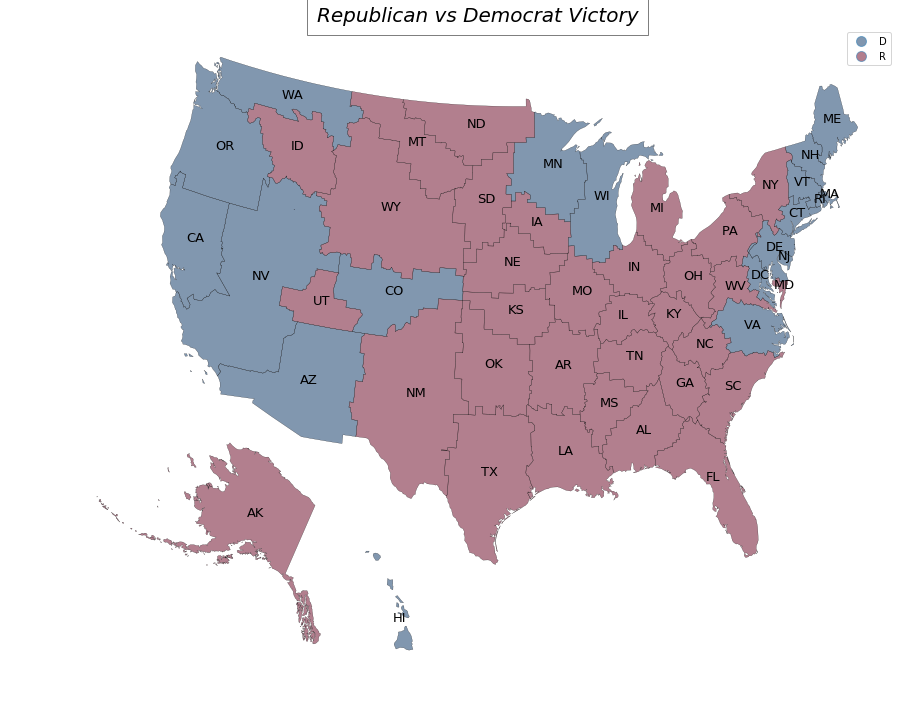

In [29]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(15,12))
for p, state_ab, winner in zip(states.geometry, states.newstate, states.win):
    # set up text
    ax.annotate(xy=(p.centroid.x-49000, p.centroid.y), s=state_ab, size=13)
    #ax.annotate(xy=(p.centroid.x-40000, p.centroid.y-60000), s=winner, size=8)
    # plot states
    ax.set_title("Republican vs Democrat Victory", fontsize=20, style='italic',
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
    #fig.suptitle('New Map Results', fontsize=20, fontweight='bold')
    ax.axis('off')
states.plot(ax=ax, column='win', cmap="RdBu_r", linewidth=.2, legend=True)


In [30]:
newdf = randomize_election()

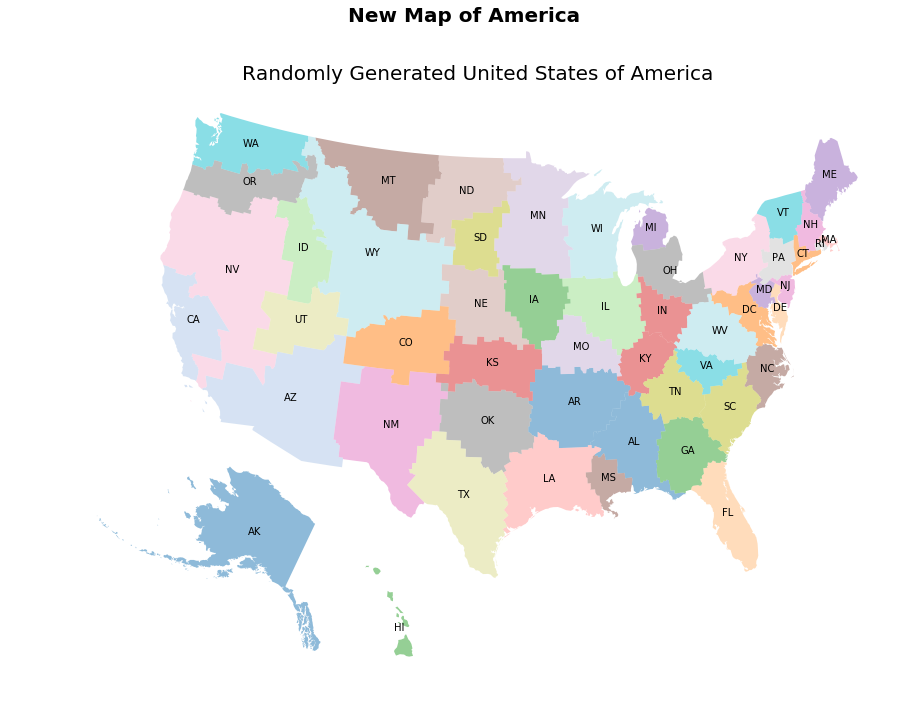

In [31]:
plot_single_new_states(newdf)

# Randomly Generate 4 maps


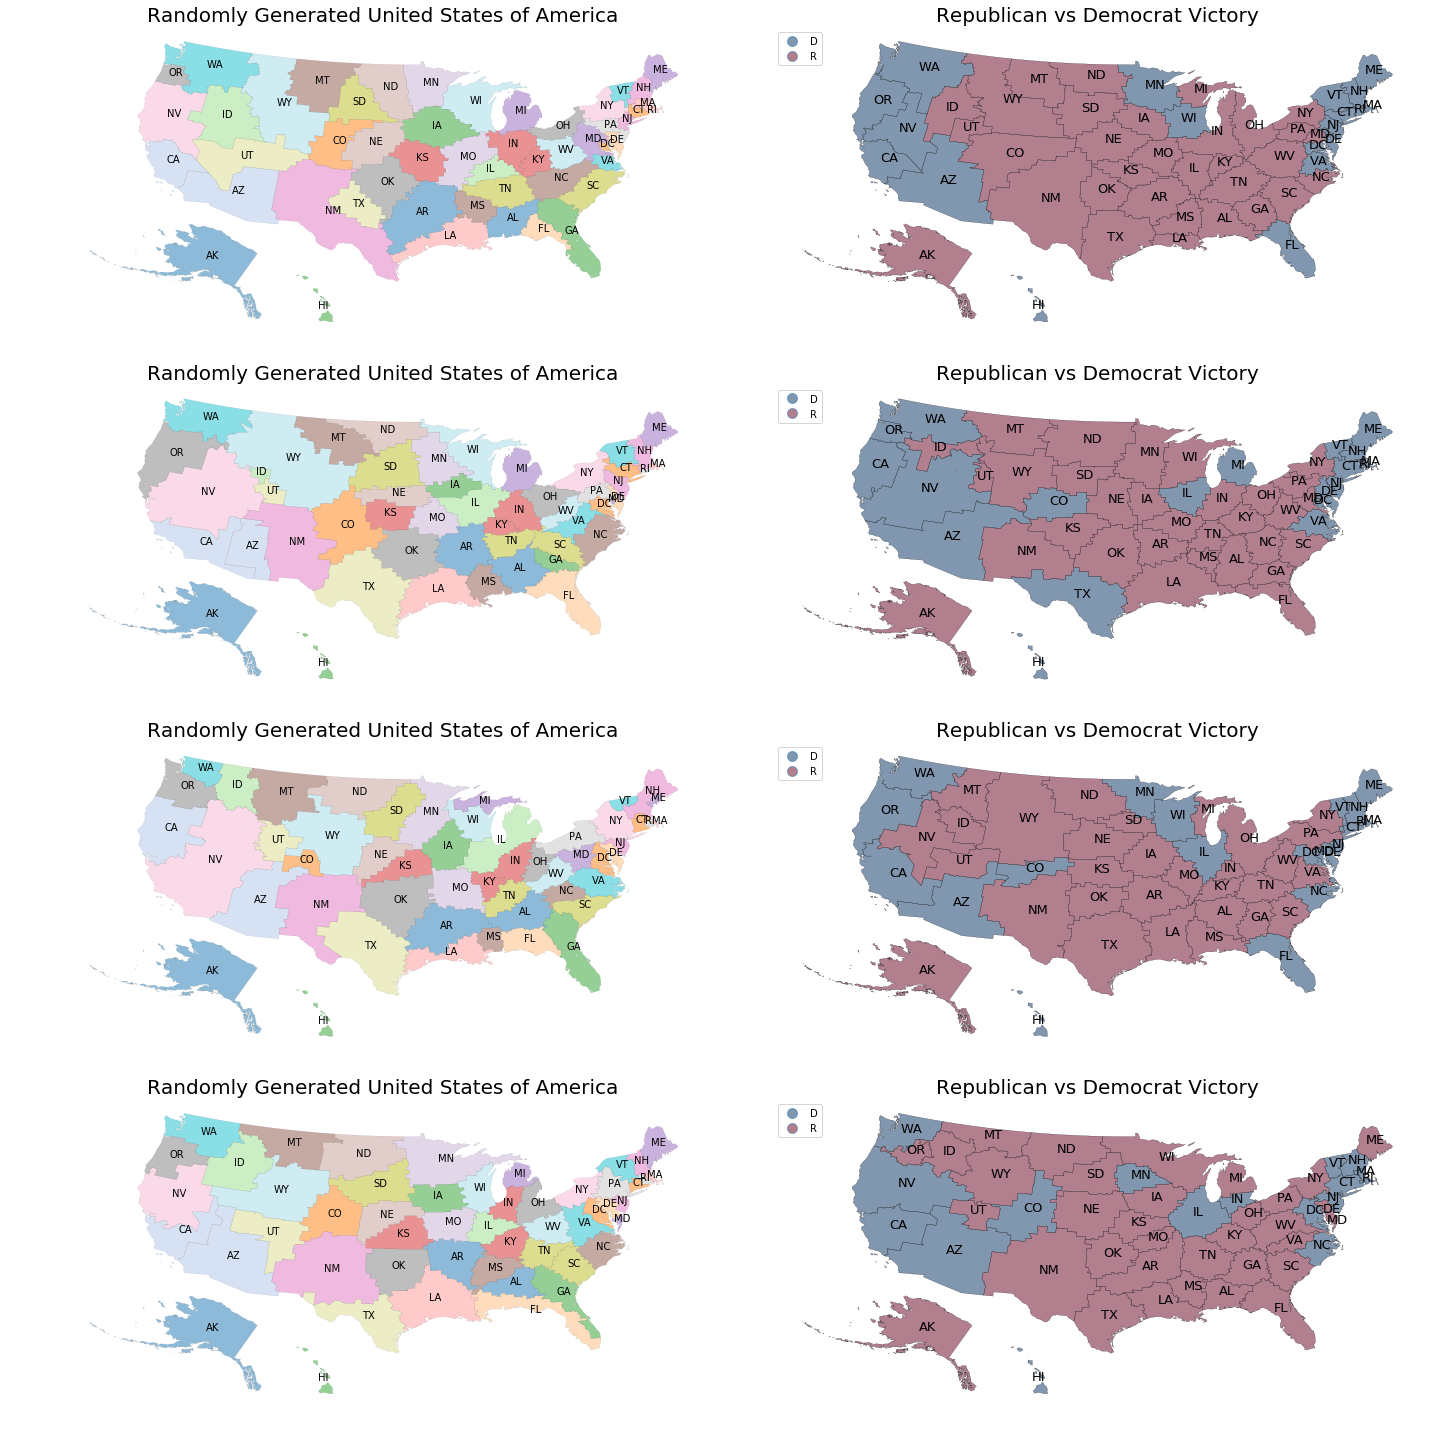

In [32]:
# same as above, but in loop
fig = plt.figure(figsize=(20,20))
for i in xrange(8):
    new_states = randomize_election()
    ax = fig.add_subplot(4,2,i+1)
    if i % 2 == 0:
        for p, t in zip(new_states.geometry, new_states.newstate):
            # set up text
            ax.annotate(xy=(p.centroid.x-40000, p.centroid.y), s=t)
            # plot states
            ax.set_title("Randomly Generated United States of America", fontsize=20)
            ax.axis('off')
        new_states.plot(ax=ax, column='newstate', cmap="Vega20", linewidth=0.05)
    else:
        for p, state_ab, winner in zip(new_states.geometry, new_states.newstate, new_states.win):
            # set up text
            ax.annotate(xy=(p.centroid.x-49000, p.centroid.y), s=state_ab, size=13)
            #ax.annotate(xy=(p.centroid.x-40000, p.centroid.y-60000), s=winner, size=8)
            # plot states
            ax.set_title("Republican vs Democrat Victory", fontsize=20)
            ax.axis('off')
        new_states.plot(ax=ax, column='win', cmap="RdBu_r", linewidth=.2, legend=True)
    plt.tight_layout()

In [33]:
def plot_multiple_new_states(k=4):
    """Plots k/2 iterations of randomly generated states, alongside their vote distribution"""
    
    if k%2==1:
        raise ValueError("k must be an even integer")
    
    fig = plt.figure(figsize=(12+k,8+k))
    for i in xrange(k):
        new_states = randomize_election()
        ax = fig.add_subplot(k/2.,2,i+1)
        if i % 2 == 0:
            for p, t in zip(new_states.geometry, new_states.newstate):
                # set up text
                ax.annotate(xy=(p.centroid.x-40000, p.centroid.y), s=t)
                # plot states
                ax.set_title("Randomly Generated States", fontsize=20, fontweight="bold")
                ax.axis('off')
            new_states.plot(ax=ax, column='newstate', cmap="Vega20", linewidth=0.05)
        else:
            for p, state_ab, winner in zip(new_states.geometry, new_states.newstate, new_states.win):
                # set up text
                ax.annotate(xy=(p.centroid.x-49000, p.centroid.y), s=state_ab, size=13)
                #ax.annotate(xy=(p.centroid.x-40000, p.centroid.y-60000), s=winner, size=8)
                # plot states
                ax.set_title("Republican vs Democrat Victory", fontsize=20, fontweight="bold")
                ax.axis('off')
            new_states.plot(ax=ax, column='win', cmap="RdBu_r", linewidth=.2, legend=True)
        plt.tight_layout()

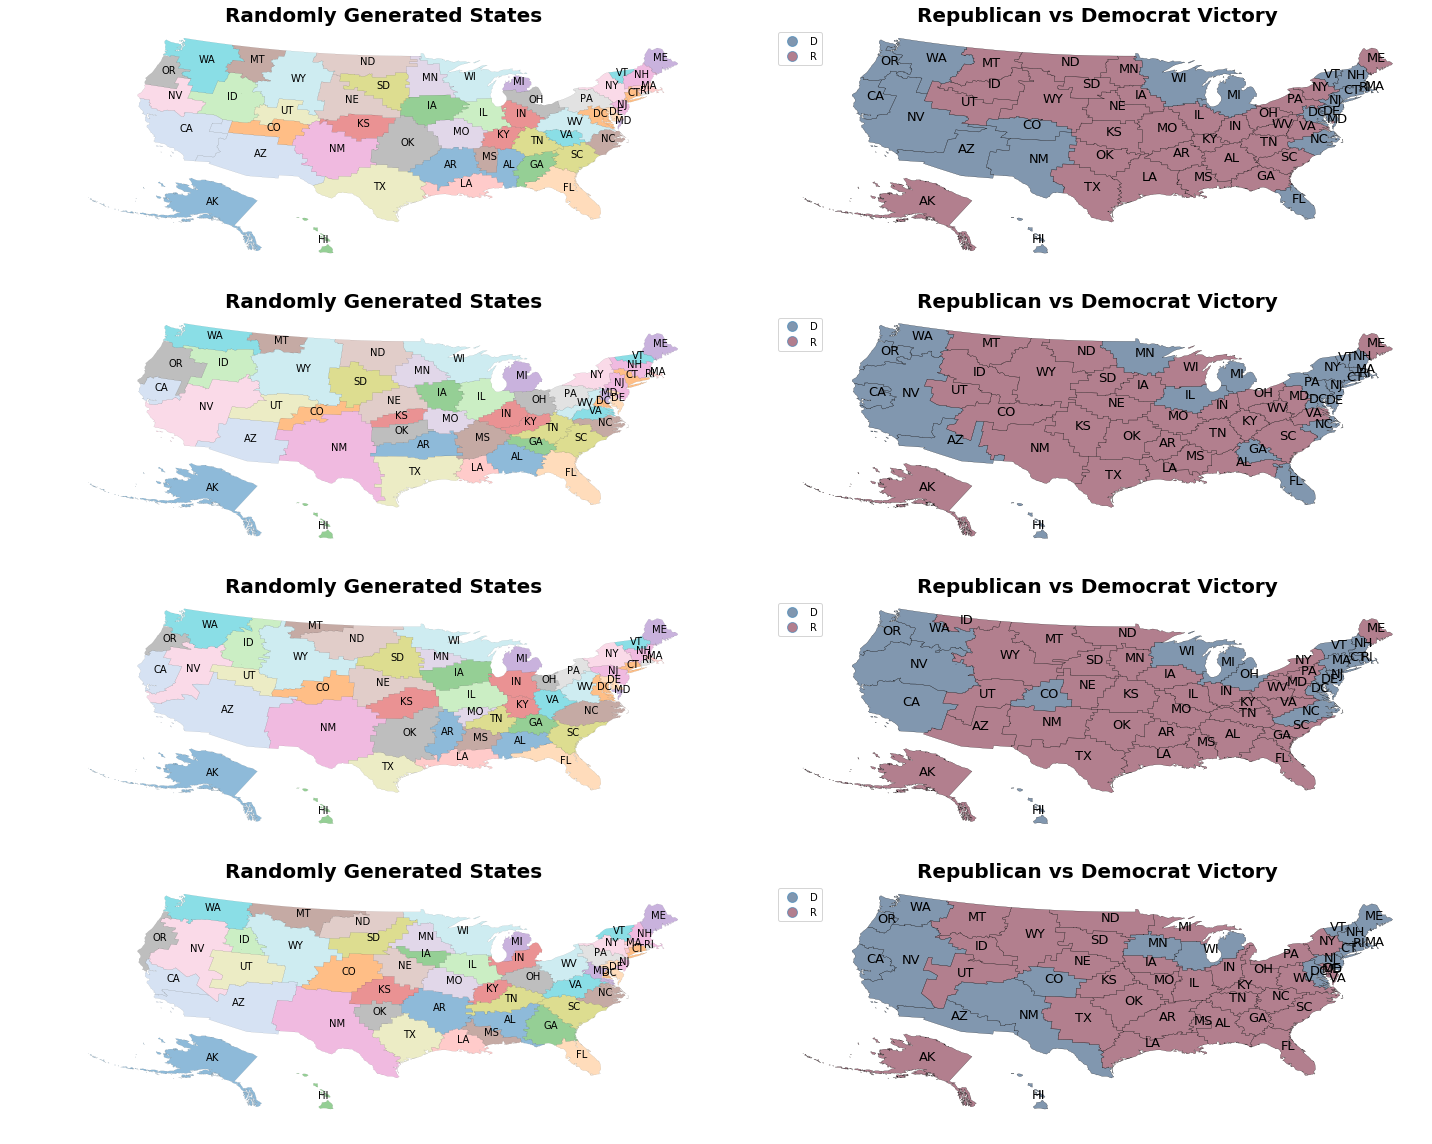

In [34]:
plot_multiple_new_states(8)

# Plots Specific to Data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123c06290>]], dtype=object)

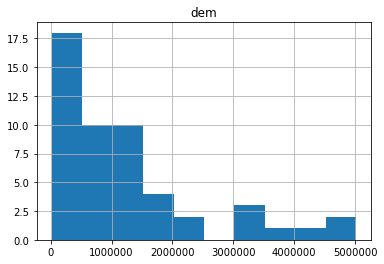

In [35]:
states.hist('dem')

In [36]:
states.head()

,newstate,geometry,FID,dem,dempc,gop,goppc,grn,lib,margin,oth,population,una,votes,win
0,AK,(POLYGON ((-1882164.772212857 419730.666193547...,2001,93007,0.377176,130415,0.528878,4445,14593,0.151702,4128,710231,0,246588,R
1,AL,(POLYGON ((881156.8469885951 855009.1992311808...,849036,851971,0.359155,1457930,0.614603,9811,49846,0.255447,2593,5505612,0,2372151,R
2,AR,"POLYGON ((187755.7008467465 1189168.26751307, ...",1487254,477254,0.293165,1075255,0.660502,13393,47663,0.367337,14371,4083984,0,1627936,R
3,AZ,POLYGON ((-1365876.729939255 1021579.408853245...,319510,1851917,0.494778,1688734,0.451180,50540,146005,-0.043598,5732,11943290,0,3742928,D
4,CA,"POLYGON ((-2179243.116936406 1809137.0638182, ...",462122,3068842,0.637718,1450637,0.301449,90792,172659,-0.336270,29291,13277113,0,4812221,D


# Barplot of Votes by State

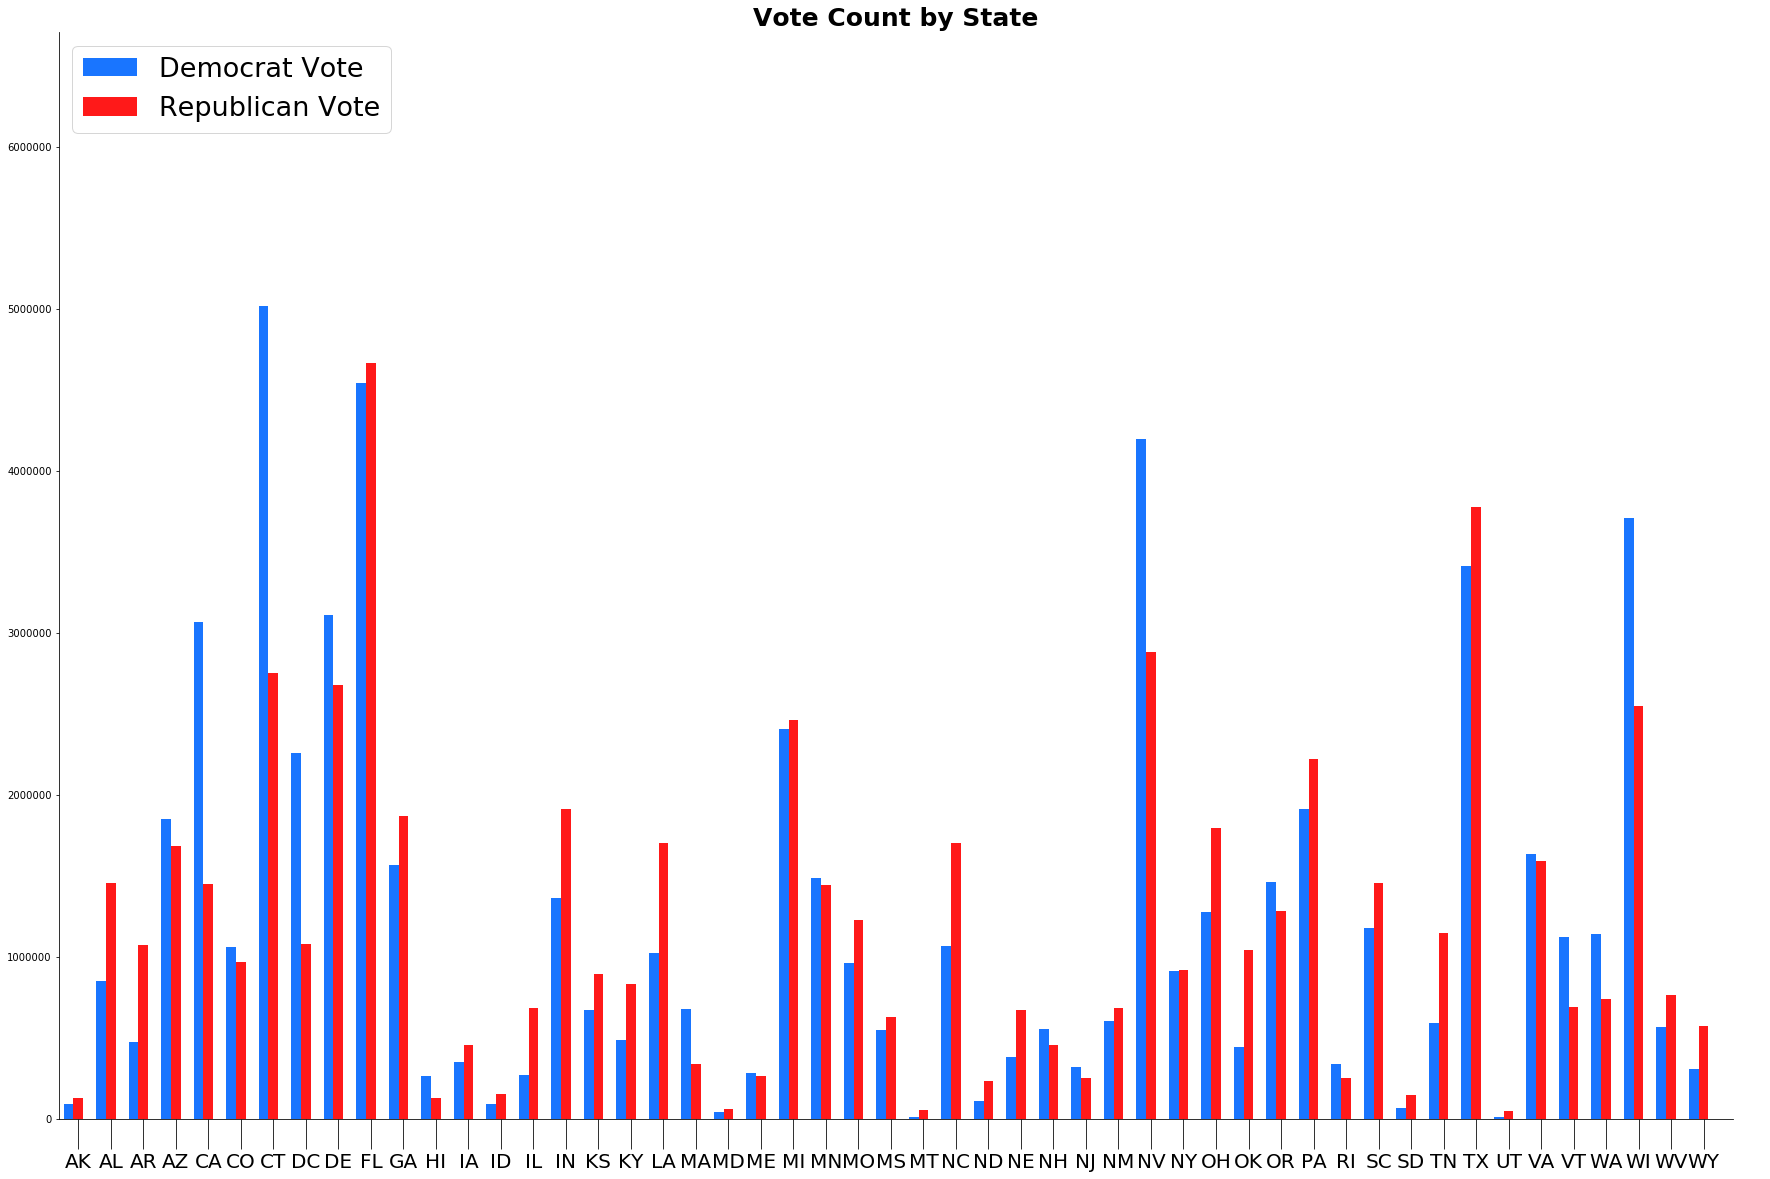

In [37]:
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
# Setting the positions and width for the bars
pos = list(range(len(states['dem'])))
width = 0.3

# Plotting the bars
fig, ax = plt.subplots(figsize=(30,20))


plt.bar(pos,
        #using df['pre_score'] data,
        states['dem'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.9,
        # with color
        color='#0066ff',
        # with label the first value in first_name
        label=states['newstate'][0])


plt.bar([p + width for p in pos],
        #using df['mid_score'] data,
        states['gop'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.9,
        # with color
        color='#ff0000',
        # with label the second value in first_name
        label=states['newstate'][1])


#ax.set_ylabel('Vote Count')

# Set the chart's title
ax.set_title('Vote Count by State', size=25, fontweight='bold')

# Set the position of the x ticks
ax.set_xticks([p + 1 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(states['newstate'])
plt.tick_params(axis='x', which='major', labelsize=20, length=30)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(states['dem'] + states['gop'])-2500000] )
#ax.axis('off')
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.yaxis.grid(False) # horizontal lines
ax.xaxis.grid(False)
ax.grid(False)
#ax.right_ax(False)
# Adding the legend and showing the plot
plt.legend(['Democrat Vote', 'Republican Vote'], loc='upper left', fontsize=27, frameon=True)
plt.show()

# Barplot of Total Votes

In [40]:
table = pd.DataFrame({'dem_sum':states['dem'].sum(),
                     'rep_sum':states['gop'].sum()}, 
                    index=[0])
table

,dem_sum,rep_sum
0,62296378,61059569


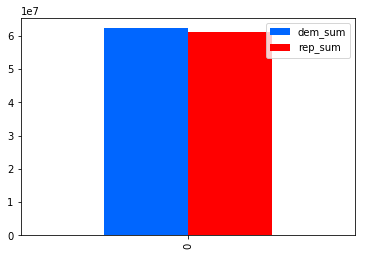

In [41]:
table.plot(kind='bar', color=['#0066ff','#ff0000'])

# Barplot of Total State Victories

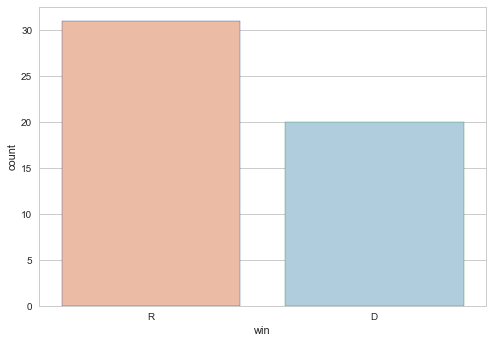

In [492]:
sns.set_style("whitegrid")
sns.countplot(x="win", data=states, palette="RdBu",edgecolor=sns.color_palette("dark", 2))